In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [2]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power_two_sample import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
simulations = {'multi_noise': (multi_noise_sim, 19)}

In [4]:
def power_vs_angle_parallel(params_dict):
    angles = [i for i in range(0, 99, 9)]
    estimated_power = np.zeros(len(angles))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(angles)):
        estimated_power[i] = power_given_data(test, sim, data_type='angle', num_samples=100, num_dimensions=1, theta=angles[i])
    
    np.savetxt('{}_{}_angle_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [5]:
def make_sim_list(params_dict):
    sim = params_dict['simulation_type']
    return sim

In [6]:
def fill_params_dict_list_angles():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [7]:
%%time
params_dict = fill_params_dict_list_angles()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_angle_parallel, params_dict)

<class 'list'>
19 unbiased
19 biased
19 mantel
19 mantel finished
19 biased finished
19 unbiased finished
CPU times: user 64.5 ms, sys: 37.2 ms, total: 102 ms
Wall time: 1min 32s


In [12]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_angle_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [i for i in range(0,99,9)]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle')
    plt.savefig('power_curves_angles_new')

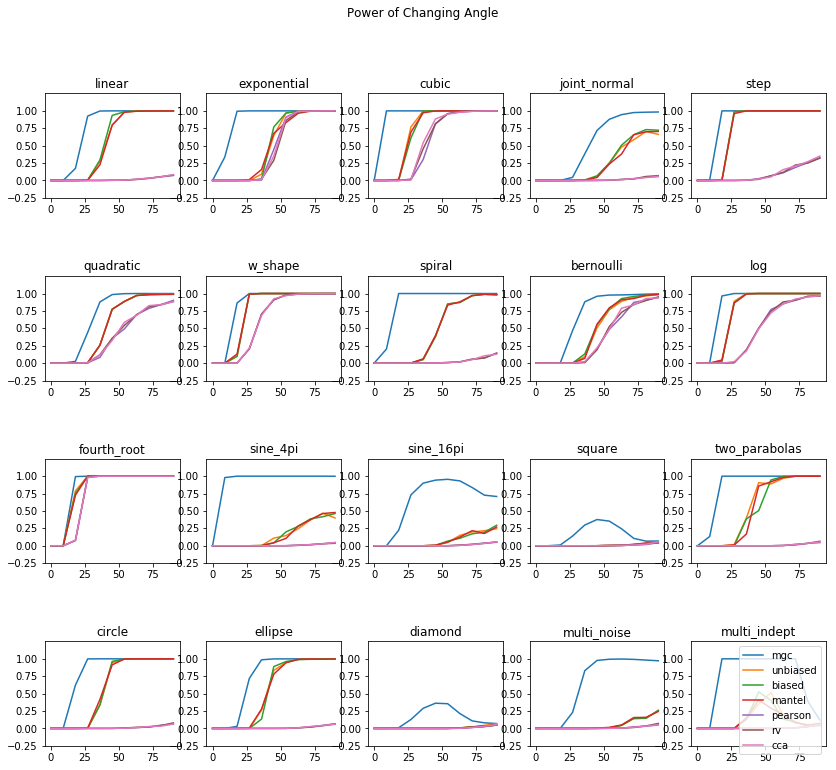

In [13]:
plot_all_curves()

In [10]:
def plot_diff():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond']
        
        
    fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']

            for test in tests:
                power = np.genfromtxt('{}_{}_angle_matlab.csv'.format(simulation_type, test), delimiter=',')
                new_power = np.genfromtxt('{}_{}_angle_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                diff = new_power - power
                x_axis = [i for i in range(0,200,20)]
                col.plot(x_axis, diff, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle for New Transform Function vs Old Transform Function')
    plt.savefig('power_curves_angles_diff')

In [11]:
#plot_diff()